In [63]:
pip install squarify

Note: you may need to restart the kernel to use updated packages.


In [64]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import squarify
import json

pd.options.display.float_format = '{:,.2f}'.format

In [65]:
pip install geopandas

In [66]:
import geopandas as gpd
from bokeh.io import output_notebook, show, output_file
from bokeh.plotting import figure
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar
from bokeh.palettes import brewer
from bokeh.models import HoverTool

In [68]:
df = pd.read_csv(r'D:\bp_sales_dataset.csv')


In [71]:
#change customer names to all uppercase
df['Customer'] = df['Customer'].str.upper()

In [72]:
df.columns = [col.lower().replace(' ', '_') for col in df.columns]

In [73]:
df.head()

,id,date,description,qty,retail,subtotal,discount,tax,total,customer,source,work_order_internal_note
0,500945,3/14/2022,AIR TOOL SWITCH SPORT BLK,1,20.00,20.00,0.00,0%,20.00,CHRISTOPHER VASQUEZ,NaN,NaN
1,500992,3/14/2022,"AETHON, CRYSTAL SMOKE/WHITE FOTOTEC SUNGLASSE...",-1,79.99,-79.99,0.00,9.25%,-87.39,SUSAN JABLONSKI,NaN,NaN
2,501065,3/14/2022,"EVO, HIGHTAIL, PLATFORM PEDALS, BODY: ALUMINUM...",1,34.99,34.99,0.00,9.25%,38.23,MARCIA MCDONALD,NaN,NaN
3,501065,3/14/2022,BH - PEDAL - INSTALL - PEDALS - PAIR,1,5.00,5.00,0.00,0%,5.00,MARCIA MCDONALD,NaN,NaN
4,501065,3/14/2022,ALIGN II HLMT MIPS CPSC BLK/BLKREFL S/M,1,55.00,55.00,0.00,9.25%,60.09,MARCIA MCDONALD,NaN,NaN


In [74]:
df = df.drop(['subtotal','tax', 'source', 'work_order_internal_note'], axis=1)


In [75]:
df['date'] = pd.to_datetime(df['date'])

In [76]:
df.head()

,id,date,description,qty,retail,discount,total,customer
0,500945,2022-03-14,AIR TOOL SWITCH SPORT BLK,1,20.00,0.00,20.00,CHRISTOPHER VASQUEZ
1,500992,2022-03-14,"AETHON, CRYSTAL SMOKE/WHITE FOTOTEC SUNGLASSE...",-1,79.99,0.00,-87.39,SUSAN JABLONSKI
2,501065,2022-03-14,"EVO, HIGHTAIL, PLATFORM PEDALS, BODY: ALUMINUM...",1,34.99,0.00,38.23,MARCIA MCDONALD
3,501065,2022-03-14,BH - PEDAL - INSTALL - PEDALS - PAIR,1,5.00,0.00,5.00,MARCIA MCDONALD
4,501065,2022-03-14,ALIGN II HLMT MIPS CPSC BLK/BLKREFL S/M,1,55.00,0.00,60.09,MARCIA MCDONALD


In [77]:
from datetime import date

In [78]:
today = date. today()

In [79]:
max_date = df['date'].min()
print(max_date)

2022-03-14 00:00:00


In [80]:
#change date data to datetime
today=pd.to_datetime(today)
max_date=pd.to_datetime(max_date)

In [81]:
agg_dict1 = {
    'id': 'count',
    'date': 'max',
    'retail': 'sum'
}

df_rfm = df.groupby('customer').agg(agg_dict1).reset_index()
df_rfm.columns = ['customer', 'frequency', 'max_date', 'monetary']
df_rfm['recency'] = (today - df_rfm['max_date']).dt.days
df_rfm.drop(['max_date'], axis=1, inplace=True)

In [82]:
r_labels, f_labels, m_labels = range(5, 0, -1), range(1,6), range(1,6)

In [83]:
df_rfm['r_score'] = pd.qcut(df_rfm['recency'], q=5, labels=r_labels).astype(int)

In [84]:
df_rfm['f_score'] = pd.qcut((df_rfm.rank(method='first'))['frequency'], q=5, labels=f_labels).astype(int)


In [85]:
df_rfm['m_score'] = pd.qcut(df_rfm['monetary'], q=5, labels=m_labels).astype(int)


In [86]:
df_rfm['rfm_sum'] = df_rfm['r_score'] + df_rfm['f_score'] + df_rfm['m_score']

In [87]:
def assign_label(df, r_rule, fm_rule, label, colname='rfm_label'):
    df.loc[(df['r_score'].between(r_rule[0], r_rule[1]))
            & (df['f_score'].between(fm_rule[0], fm_rule[1])), colname] = label
    return df

In [88]:
df.head()

,id,date,description,qty,retail,discount,total,customer
0,500945,2022-03-14,AIR TOOL SWITCH SPORT BLK,1,20.00,0.00,20.00,CHRISTOPHER VASQUEZ
1,500992,2022-03-14,"AETHON, CRYSTAL SMOKE/WHITE FOTOTEC SUNGLASSE...",-1,79.99,0.00,-87.39,SUSAN JABLONSKI
2,501065,2022-03-14,"EVO, HIGHTAIL, PLATFORM PEDALS, BODY: ALUMINUM...",1,34.99,0.00,38.23,MARCIA MCDONALD
3,501065,2022-03-14,BH - PEDAL - INSTALL - PEDALS - PAIR,1,5.00,0.00,5.00,MARCIA MCDONALD
4,501065,2022-03-14,ALIGN II HLMT MIPS CPSC BLK/BLKREFL S/M,1,55.00,0.00,60.09,MARCIA MCDONALD


In [89]:
df_rfm['rfm_label'] = ''

df_rfm = assign_label(df_rfm, (5,5), (4,5), 'champions')
df_rfm = assign_label(df_rfm, (3,4), (4,5), 'loyal customers')
df_rfm = assign_label(df_rfm, (4,5), (2,3), 'potential loyalist')
df_rfm = assign_label(df_rfm, (5,5), (1,1), 'new customers')
df_rfm = assign_label(df_rfm, (4,4), (1,1), 'promising')
df_rfm = assign_label(df_rfm, (3,3), (3,3), 'needing attention')
df_rfm = assign_label(df_rfm, (3,3), (1,2), 'about to sleep')
df_rfm = assign_label(df_rfm, (1,2), (3,4), 'at risk')
df_rfm = assign_label(df_rfm, (1,2), (5,5), 'cant loose them')
df_rfm = assign_label(df_rfm, (1,2), (1,2), 'hibernating')

C:\Users\Mat\AppData\Local\Temp\ipykernel_45368\3211360976.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_rfm[col])


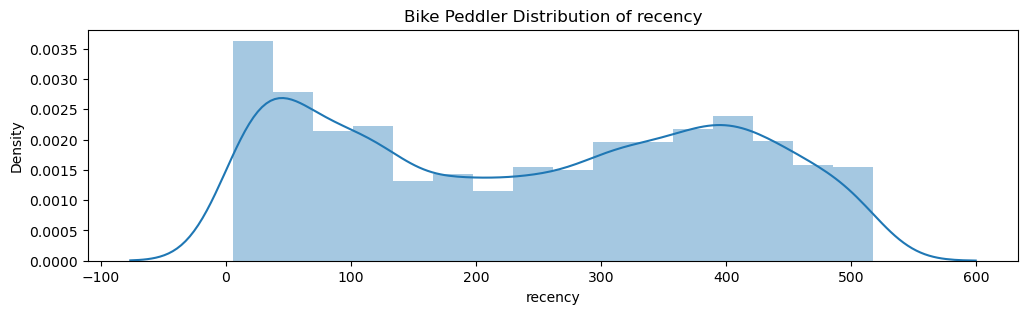

C:\Users\Mat\AppData\Local\Temp\ipykernel_45368\3211360976.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_rfm[col])


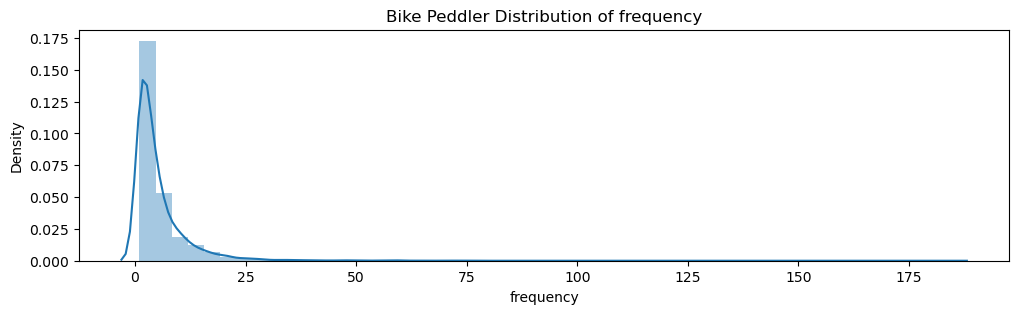

C:\Users\Mat\AppData\Local\Temp\ipykernel_45368\3211360976.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_rfm[col])


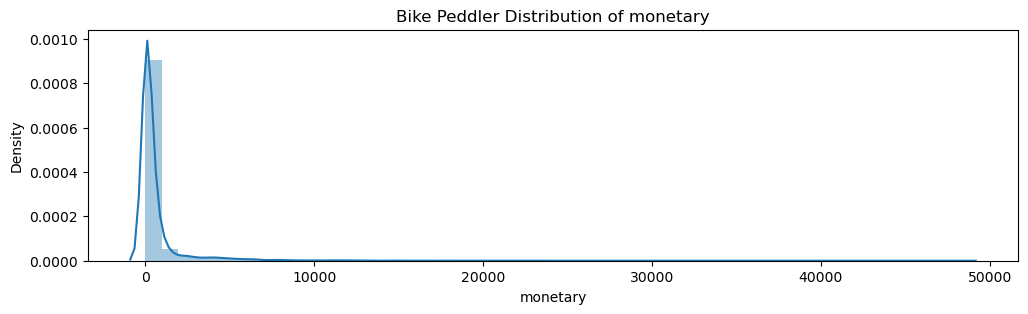

In [90]:
colnames = ['recency', 'frequency', 'monetary']

for col in colnames:
    fig, ax = plt.subplots(figsize=(12,3))
    sns.distplot(df_rfm[col])
    ax.set_title('Bike Peddler Distribution of %s' % col)
    plt.show()

C:\Users\Mat\AppData\Local\Temp\ipykernel_45368\2290199572.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_rfm[df_rfm['rfm_label']==segment][col], label=segment)
C:\Users\Mat\AppData\Local\Temp\ipykernel_45368\2290199572.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_rfm[df_rfm['r

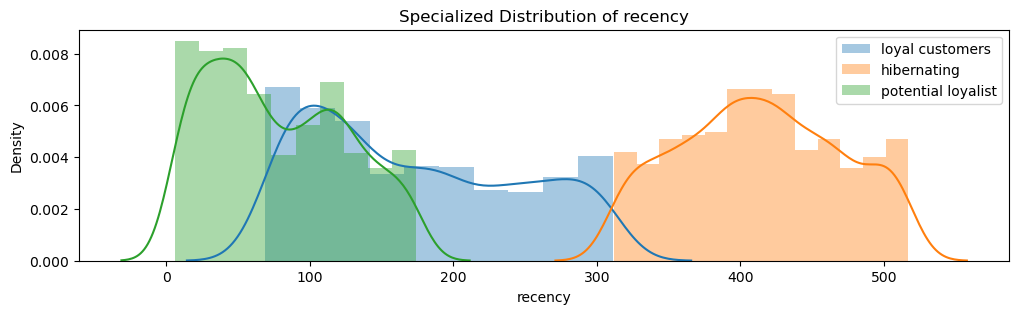

C:\Users\Mat\AppData\Local\Temp\ipykernel_45368\2290199572.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_rfm[df_rfm['rfm_label']==segment][col], label=segment)
C:\Users\Mat\AppData\Local\Temp\ipykernel_45368\2290199572.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_rfm[df_rfm['r

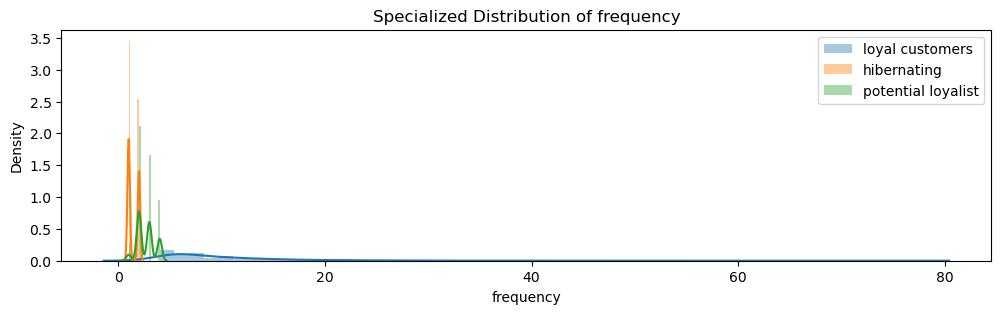

C:\Users\Mat\AppData\Local\Temp\ipykernel_45368\2290199572.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_rfm[df_rfm['rfm_label']==segment][col], label=segment)
C:\Users\Mat\AppData\Local\Temp\ipykernel_45368\2290199572.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_rfm[df_rfm['r

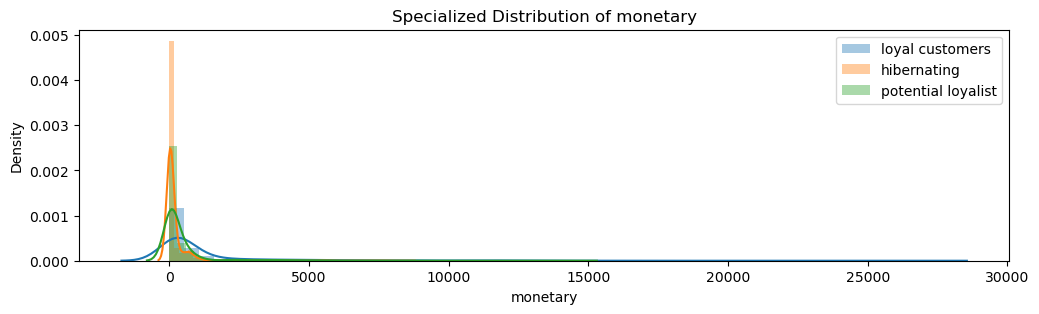

In [91]:
segments = ['loyal customers', 'hibernating', 'potential loyalist']

for col in colnames:
    fig, ax = plt.subplots(figsize=(12,3))
    for segment in segments:
        sns.distplot(df_rfm[df_rfm['rfm_label']==segment][col], label=segment)
    ax.set_title('Specialized Distribution of %s' % col)
    plt.legend()
    plt.show()

In [92]:
df.head()

,id,date,description,qty,retail,discount,total,customer
0,500945,2022-03-14,AIR TOOL SWITCH SPORT BLK,1,20.00,0.00,20.00,CHRISTOPHER VASQUEZ
1,500992,2022-03-14,"AETHON, CRYSTAL SMOKE/WHITE FOTOTEC SUNGLASSE...",-1,79.99,0.00,-87.39,SUSAN JABLONSKI
2,501065,2022-03-14,"EVO, HIGHTAIL, PLATFORM PEDALS, BODY: ALUMINUM...",1,34.99,0.00,38.23,MARCIA MCDONALD
3,501065,2022-03-14,BH - PEDAL - INSTALL - PEDALS - PAIR,1,5.00,0.00,5.00,MARCIA MCDONALD
4,501065,2022-03-14,ALIGN II HLMT MIPS CPSC BLK/BLKREFL S/M,1,55.00,0.00,60.09,MARCIA MCDONALD


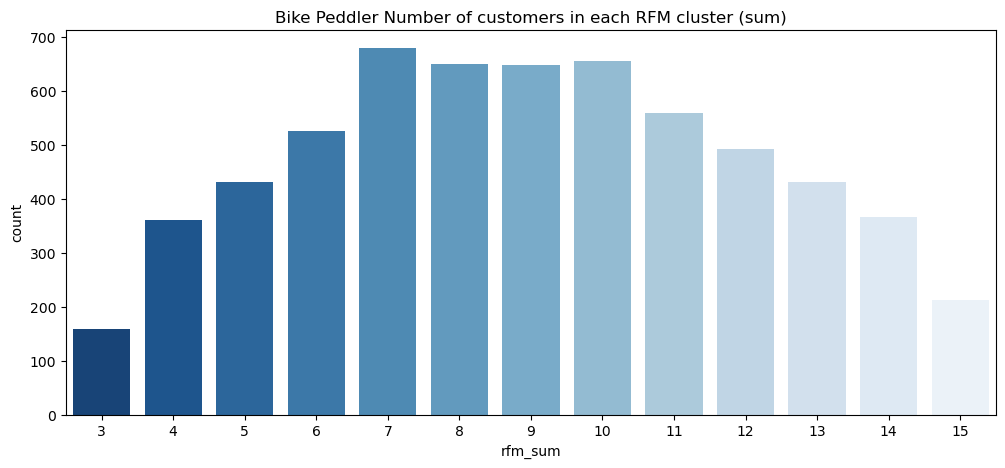

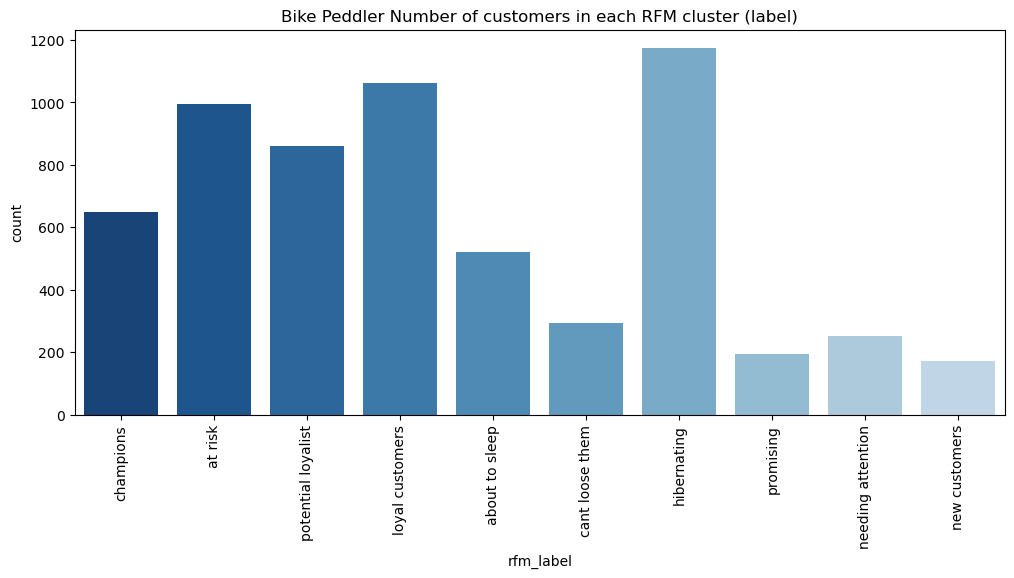

In [93]:
palette = sns.color_palette("Blues_r", n_colors=13)

for rfm_type in ['sum', 'label']:
    fig, ax = plt.subplots(figsize=(12,5))
    sns.countplot(x='rfm_'+rfm_type, data=df_rfm, palette=palette)
    ax.set_title('Bike Peddler Number of customers in each RFM cluster (%s)' % rfm_type)
    if rfm_type == 'label':
        plt.xticks(rotation=90)
    plt.show()

In [94]:
agg_dict2 = {
    'customer': 'count',
    'recency': 'mean',
    'frequency': 'mean',
    'monetary': 'sum'
}

df_analysis = df_rfm.groupby('rfm_label').agg(agg_dict2).sort_values(by='recency').reset_index()
df_analysis.rename({'rfm_label': 'label', 'customer': 'count'}, axis=1, inplace=True)
df_analysis['count_share'] = df_analysis['count'] / df_analysis['count'].sum()
df_analysis['monetary_share'] = df_analysis['monetary'] / df_analysis['monetary'].sum()
df_analysis['monetary'] = df_analysis['monetary'] / df_analysis['count']

In [100]:
df.head()

,id,date,description,qty,retail,discount,total,customer
0,500945,2022-03-14,AIR TOOL SWITCH SPORT BLK,1,20.00,0.00,20.00,CHRISTOPHER VASQUEZ
1,500992,2022-03-14,"AETHON, CRYSTAL SMOKE/WHITE FOTOTEC SUNGLASSE...",-1,79.99,0.00,-87.39,SUSAN JABLONSKI
2,501065,2022-03-14,"EVO, HIGHTAIL, PLATFORM PEDALS, BODY: ALUMINUM...",1,34.99,0.00,38.23,MARCIA MCDONALD
3,501065,2022-03-14,BH - PEDAL - INSTALL - PEDALS - PAIR,1,5.00,0.00,5.00,MARCIA MCDONALD
4,501065,2022-03-14,ALIGN II HLMT MIPS CPSC BLK/BLKREFL S/M,1,55.00,0.00,60.09,MARCIA MCDONALD


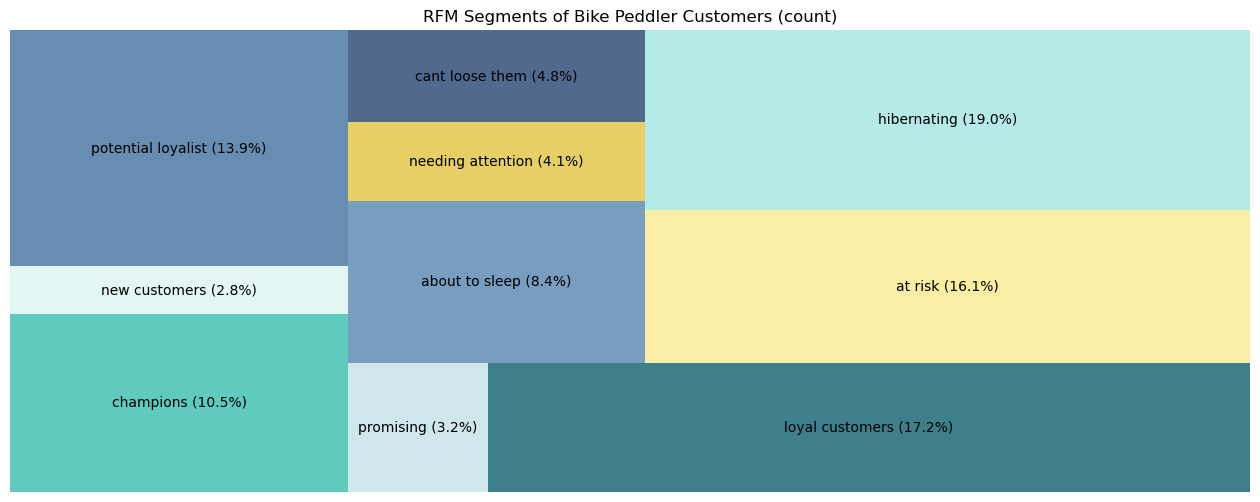

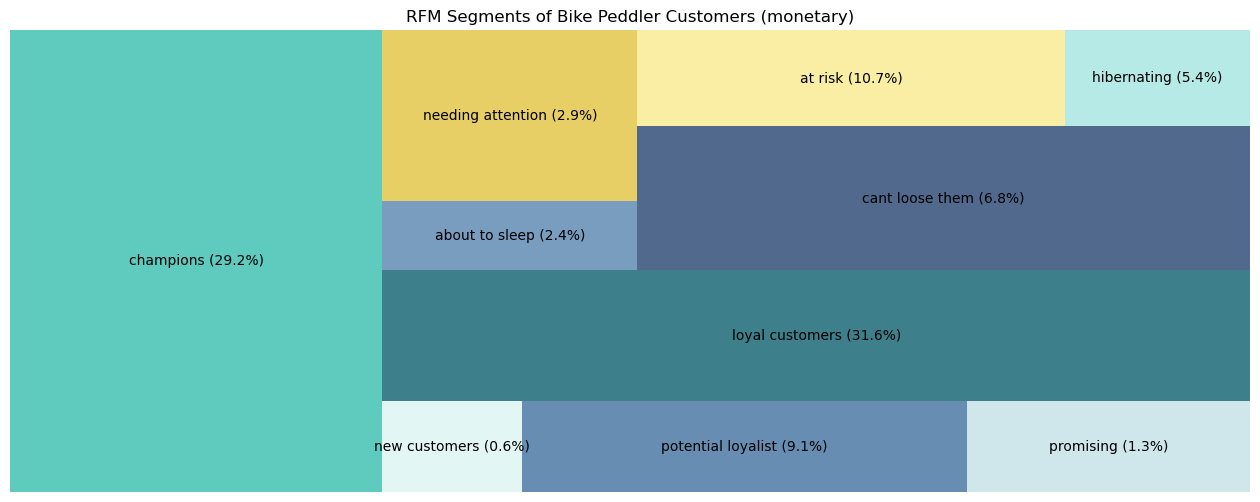

In [96]:
colors = ['#37BEB0', '#DBF5F0', '#41729F', '#C3E0E5', '#0C6170', '#5885AF', '#E1C340', '#274472', '#F8EA8C', '#A4E5E0', '#1848A0']

for col in ['count', 'monetary']:
    labels = df_analysis['label'] + df_analysis[col + '_share'].apply(lambda x: ' ({0:.1f}%)'.format(x*100))

    fig, ax = plt.subplots(figsize=(16,6))
    squarify.plot(sizes=df_analysis[col], label=labels, alpha=.8, color=colors)
    ax.set_title('RFM Segments of Bike Peddler Customers (%s)' % col)
    plt.axis('off')
    plt.show()

In [101]:
df.head()

,id,date,description,qty,retail,discount,total,customer
0,500945,2022-03-14,AIR TOOL SWITCH SPORT BLK,1,20.00,0.00,20.00,CHRISTOPHER VASQUEZ
1,500992,2022-03-14,"AETHON, CRYSTAL SMOKE/WHITE FOTOTEC SUNGLASSE...",-1,79.99,0.00,-87.39,SUSAN JABLONSKI
2,501065,2022-03-14,"EVO, HIGHTAIL, PLATFORM PEDALS, BODY: ALUMINUM...",1,34.99,0.00,38.23,MARCIA MCDONALD
3,501065,2022-03-14,BH - PEDAL - INSTALL - PEDALS - PAIR,1,5.00,0.00,5.00,MARCIA MCDONALD
4,501065,2022-03-14,ALIGN II HLMT MIPS CPSC BLK/BLKREFL S/M,1,55.00,0.00,60.09,MARCIA MCDONALD


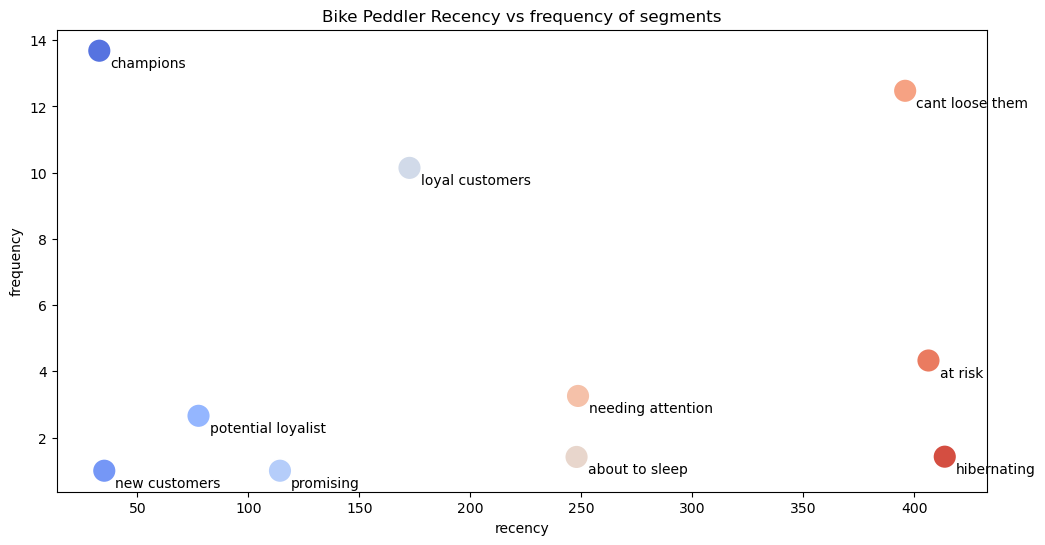

In [102]:
palette = sns.color_palette("coolwarm", 10)

fig, ax = plt.subplots(figsize=(12,6))
plot = sns.scatterplot(x='recency', y='frequency', data=df_analysis, hue='label', s=300, palette=palette)

for i in range(len(df_analysis)):
     plot.text(df_analysis['recency'][i]+5,
               df_analysis['frequency'][i]-0.5,
               df_analysis['label'][i],
               horizontalalignment='left',
               size='medium', color='black')

ax.set_title('Bike Peddler Recency vs frequency of segments')
ax.get_legend().remove()
plt.show()

In [103]:
display(df_rfm)

,customer,frequency,monetary,recency,r_score,f_score,m_score,rfm_sum,rfm_label
0,,18,158.94,16,5,5,3,13,champions
1,ANDREW,3,25.50,417,1,3,1,5,at risk
2,AARON NELSON,4,75.00,486,1,3,3,7,at risk
3,AARON BEHRENS,17,273.91,11,5,5,4,14,champions
4,AARON BESEDA,4,506.98,26,5,3,4,12,potential loyalist
...,...,...,...,...,...,...,...,...,...
6169,ZACK REINMAN,20,"4,893.89",134,4,5,5,14,loyal customers
6170,ZACK STEPHENS,8,"1,733.94",27,5,5,5,15,champions
6171,ZANE SAXTON,2,199.00,320,2,3,4,9,at risk
6172,ZEC PEREZ,4,25.98,266,3,4,1,8,loyal customers


In [104]:
df.head()

,id,date,description,qty,retail,discount,total,customer
0,500945,2022-03-14,AIR TOOL SWITCH SPORT BLK,1,20.00,0.00,20.00,CHRISTOPHER VASQUEZ
1,500992,2022-03-14,"AETHON, CRYSTAL SMOKE/WHITE FOTOTEC SUNGLASSE...",-1,79.99,0.00,-87.39,SUSAN JABLONSKI
2,501065,2022-03-14,"EVO, HIGHTAIL, PLATFORM PEDALS, BODY: ALUMINUM...",1,34.99,0.00,38.23,MARCIA MCDONALD
3,501065,2022-03-14,BH - PEDAL - INSTALL - PEDALS - PAIR,1,5.00,0.00,5.00,MARCIA MCDONALD
4,501065,2022-03-14,ALIGN II HLMT MIPS CPSC BLK/BLKREFL S/M,1,55.00,0.00,60.09,MARCIA MCDONALD


In [105]:
df.head()

,id,date,description,qty,retail,discount,total,customer
0,500945,2022-03-14,AIR TOOL SWITCH SPORT BLK,1,20.00,0.00,20.00,CHRISTOPHER VASQUEZ
1,500992,2022-03-14,"AETHON, CRYSTAL SMOKE/WHITE FOTOTEC SUNGLASSE...",-1,79.99,0.00,-87.39,SUSAN JABLONSKI
2,501065,2022-03-14,"EVO, HIGHTAIL, PLATFORM PEDALS, BODY: ALUMINUM...",1,34.99,0.00,38.23,MARCIA MCDONALD
3,501065,2022-03-14,BH - PEDAL - INSTALL - PEDALS - PAIR,1,5.00,0.00,5.00,MARCIA MCDONALD
4,501065,2022-03-14,ALIGN II HLMT MIPS CPSC BLK/BLKREFL S/M,1,55.00,0.00,60.09,MARCIA MCDONALD


In [48]:
df_rfm.to_excel(r'D:\bp_sales_rfmdataset.xlsx', index=False)

In [109]:
df_merge.to_csv('BP_RMF_merge.csv')

In [108]:
df_merge.to_excel(r'D:\bp_sales_rfmdataset_merge.xlsx', index=False)

In [106]:
df_merge = df.merge(df_rfm, left_on='customer', right_on='customer')


In [107]:
df_merge.head()

,id,date,description,qty,retail,discount,total,customer,frequency,monetary,recency,r_score,f_score,m_score,rfm_sum,rfm_label
0,500945,2022-03-14,AIR TOOL SWITCH SPORT BLK,1,20.00,0.00,20.00,CHRISTOPHER VASQUEZ,1,20.00,517,1,1,1,3,hibernating
1,500992,2022-03-14,"AETHON, CRYSTAL SMOKE/WHITE FOTOTEC SUNGLASSE...",-1,79.99,0.00,-87.39,SUSAN JABLONSKI,18,381.96,28,5,5,4,14,champions
2,714112,2022-07-19,SPOKE LIGHT MULTI-COLOR,2,10.00,0.00,21.85,SUSAN JABLONSKI,18,381.96,28,5,5,4,14,champions
3,714112,2022-07-19,"Boeshield T9 Bike Chain Lube - 4 fl oz, Drip",1,11.99,0.00,13.10,SUSAN JABLONSKI,18,381.96,28,5,5,4,14,champions
4,910378,2022-11-30,"(Work order #106671, Item: Diverge 700c \n-R...",1,0.00,0.00,0.00,SUSAN JABLONSKI,18,381.96,28,5,5,4,14,champions


In [60]:
#change customer names to all uppercase
df_merge['customer'] = df_merge['customer'].str.upper()